# Signal denoising

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In this notebook, we will show how to use CVXPY Layers for tasks in structured prediction, in which the examples (or inputs) and the labels (or outputs) are both vectors, belonging to sets $\mathcal X$ and $\mathcal Y$, respectively. We assume that $\mathcal Y$ is a convex set, but make no assumptions on $\mathcal X$. The goal is to predict the outputs given the inputs. Throughout, we will use $x$ to denote inputs and $y$ to denote outputs.

A *convex optimization model* is a function $\phi$ of the form
$$
\phi(x; \theta) = \mbox{argmin}_{y \in \mathcal Y} \;\; E(x, y; \theta),
$$
where the objective $E : \mathcal X \times \mathcal Y \to \mathbf{R} \cup \{\infty\}$ is convex in its second argument, and $\theta$ is the tunable parameter that we will learn. The function $E$ is the model's *energy function*, $E(x, y; \theta)$ is the *energy* of $y$ given $x$. Note that the energy function can depend arbitrarily on $x$ and $\theta$, and that infinite values of $E$ denote additional constraints on the output. Evaluating a convex optimization model  (i.e., making a prediction) involves solving a convex optimization problem to find an output $y \in \mathcal Y$ of minimum-energy.

Convex optimization models are completely general, and include classical machine learning models, like linear and logistic regression, as well as modern neural models, as special cases.

Here, we will learn a convex optimization problem to the problem of denoising corrupted signals. We are given noise-corrupted signals, which are vectors in $\mathbf{R}^n$, and the goal is to predict the true, underlying signal, which is also a vector in $\mathbf{R}^n$.

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

import latexify
latexify.latexify()

torch.set_default_tensor_type(torch.DoubleTensor)
%matplotlib inline

In [2]:
torch.random.manual_seed(0)
np.random.seed(0)
N_train = 100
N_val = 100
n = 20
m = 20
n_regions = 100
n_points_per_region = n // n_regions
Sigma_sqrt = 0.1*np.random.randn(n, n)
Sigma = Sigma_sqrt.T @ Sigma_sqrt
normal = torch.distributions.MultivariateNormal(loc=torch.zeros(n), covariance_matrix=torch.tensor(Sigma))

inputs = []
outputs = []
eval_pts = torch.linspace(0, 2*math.pi, n)
for i in range(N_train + N_val):
    b = np.random.uniform(low=1, high=3)
    y = torch.cos(b*eval_pts)
    x = y.clone()
    x += normal.sample()
    inputs.append(x)
    outputs.append(y)

inputs = torch.stack(inputs)
outputs = torch.stack(outputs)

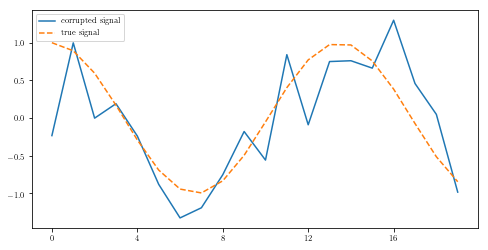

In [3]:
plt.figure(figsize=(8, 4))
plt.plot(inputs[0], label='corrupted signal')
plt.plot(outputs[0], label='true signal', linestyle='--')
plt.xticks(np.arange(n, step=4))
plt.legend()
plt.show()
plt.close()

In [4]:
X_train = inputs[:N_train]
Y_train = outputs[:N_train]

X_val = inputs[N_train:]
Y_val = outputs[N_train:]

We will denoise the input signal by solving a convex optimization problem that depends on the input; the solution of the problem will be our prediction of the denoised signal. This means that we will solve a convex optimization problem *at inference time* to obtain our prediction.

Specifically, we will use the convex optimization model
$$
\begin{array}{ll}
\hat y = \mbox{argmin}_{y} & \|M(x - y)\|_2^2 + \lambda \|Dy\|_2^2
\end{array},
$$
in which $x \in \mathbf{R}^{n}$ is the input (corrupted) signal, $y \in \mathbf{R}^{n}$ is the optimization variable, $D \in \mathbf{R}^{m \times m}$ is the first-order difference matrix; $M \in \mathbf{R}^{n \times n}$ and $\lambda \in \mathbf{R}{+}$ are the parameters in the model. Our goal is to tune the parameters $M$ and $\lambda$ using stochastic gradient descent so that on average, the solution $\hat y$ corresponding to an input $x$ closely approximates the true signal.

In the case in which $M$ is the identity matrix, this model corresponds Laplacian-regularized to least-squares denoising.

In [5]:
def create_layer():
    y_cp = cp.Variable(n)
    x_minus_y = cp.Variable(n)
    
    x_param = cp.Parameter(n)
    M_param = cp.Parameter((n, n))
    lambda_param = cp.Parameter(pos=True)
    objective = (
        cp.sum_squares(M_param @ x_minus_y) +
        lambda_param*cp.sum_squares(cp.diff(y_cp))
    )
    constraints = [
        x_minus_y == x_param - y_cp
    ]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    layer = CvxpyLayer(
        problem,
        parameters=[x_param, M_param, lambda_param],
        variables=[y_cp])
    return layer
    

layer = create_layer()

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

from tqdm.notebook import tqdm


def fit(loss, params, X, Y, Xval, Yval, batch_size=128, lr=1e-3,
        epochs=100, verbose=False, print_every=1, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(params, lr=lr)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        if callback is not None:
            callback()
            
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose and epoch % print_every == 0:
            print("val loss %03d | %3.5f" % (epoch + 1, val_losses[-1]))

        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose and epoch % print_every == 0:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
    return val_losses, train_losses

In [7]:
theta_tch = torch.eye(n, requires_grad=True)
lambda_tch = torch.tensor(0.5, requires_grad=True)
params = [theta_tch, lambda_tch]

def loss_fn(X, actual):
    preds = layer(X, theta_tch, lambda_tch)[0]
    mse_per_example = (preds - actual).pow(2).mean(axis=1)
    return mse_per_example.mean()

In [8]:
val_losses, train_losses =  fit(
    loss_fn, params, X_train, Y_train, X_val, Y_val, lr=1e-2, batch_size=64,
    epochs=15, verbose=True, print_every=1)

val loss 001 | 0.09934
batch 001 / 002 | 0.09771
batch 002 / 002 | 0.09851
val loss 002 | 0.08927
batch 001 / 002 | 0.09595
batch 002 / 002 | 0.08310
val loss 003 | 0.08134
batch 001 / 002 | 0.07604
batch 002 / 002 | 0.07687
val loss 004 | 0.07518
batch 001 / 002 | 0.07189
batch 002 / 002 | 0.06895
val loss 005 | 0.07087
batch 001 / 002 | 0.06054
batch 002 / 002 | 0.06646
val loss 006 | 0.06786
batch 001 / 002 | 0.06166
batch 002 / 002 | 0.06091
val loss 007 | 0.06513
batch 001 / 002 | 0.05749
batch 002 / 002 | 0.05811
val loss 008 | 0.06301
batch 001 / 002 | 0.05688
batch 002 / 002 | 0.05454
val loss 009 | 0.06117
batch 001 / 002 | 0.05097
batch 002 / 002 | 0.05417
val loss 010 | 0.05944
batch 001 / 002 | 0.05301
batch 002 / 002 | 0.05088
val loss 011 | 0.05784
batch 001 / 002 | 0.04594
batch 002 / 002 | 0.05161
val loss 012 | 0.05634
batch 001 / 002 | 0.05307
batch 002 / 002 | 0.04720
val loss 013 | 0.05496
batch 001 / 002 | 0.04406
batch 002 / 002 | 0.04913
val loss 014 | 0.05376
ba

In [9]:
with torch.no_grad():
    val_preds = layer(X_val, theta_tch, lambda_tch)[0]

In [10]:
y_cp = cp.Variable(n)
x_minus_y = cp.Variable(n)

x_param = cp.Parameter(n)
lambda_param = cp.Parameter(pos=True)

objective = (
    cp.sum_squares(x_param - y_cp) +
    lambda_param*cp.sum_squares(cp.diff(y_cp))
)
problem = cp.Problem(cp.Minimize(objective))
one_param_layer = CvxpyLayer(problem=problem, parameters=[x_param, lambda_param], variables=[y_cp])

In [11]:
lambda_values = torch.linspace(0, 20, 10)
best_lambda = None
lowest_loss = np.inf
for value in tqdm(lambda_values):
    preds = one_param_layer(X_val, value, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
    mse_per_example = (preds - Y_val).pow(2).mean(axis=1)
    mse = mse_per_example.mean()
    if mse < lowest_loss:
        lowest_loss = mse
        best_lambda = value

In [12]:
one_param_preds = one_param_layer(X_val, best_lambda, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
mse_per_example = (one_param_preds - Y_val).pow(2).mean(axis=1)
one_param_mse = mse_per_example.mean()
print(one_param_mse)

tensor(0.1549)


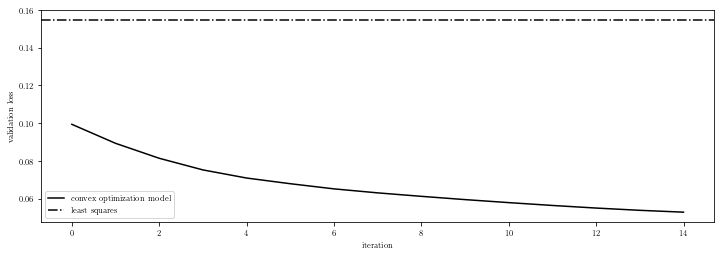

In [13]:
plt.figure(figsize=(10., 3.5))
ax = plt.gca()
plt.plot(val_losses[:100], color='k', label='convex optimization model')
ax.axhline(one_param_mse, color='k', linestyle='-.', label='least squares')
plt.legend()
plt.tight_layout()
plt.xlabel('iteration')
plt.ylabel('validation loss')
plt.show()
plt.close()

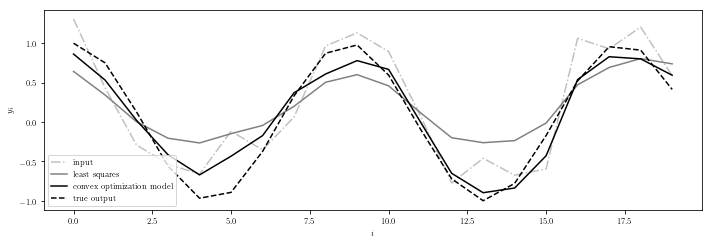

In [14]:
idx = 0
plt.figure(figsize=(10., 3.5))
plt.plot(X_val[idx], label='input', color='silver', linestyle='-.')
plt.plot(one_param_preds[idx], label='least squares', color='gray', linestyle='-',)
plt.plot(val_preds[idx], label='convex optimization model', color='k', linestyle='-')
plt.plot(Y_val[idx], label='true output', linestyle='--', color='k')
plt.xlabel('$i$')
plt.ylabel('$y_i$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
%